In [1]:
import matplotlib
import numpy as np
import math
import itertools
import sklearn
import warnings
import pandas as pd
import sklearn.linear_model
import matplotlib.pyplot as plt
from prompred import *
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Using ordinary mutalik dataset

promoter sequences range = $[-42,1]$

##### Import data

In [2]:
# Import data for model
dfDatasetOrder = pd.read_csv("data/mut_rand_mod_lib.csv")
# Shuffle
dfDataset = dfDatasetOrder.reindex(np.random.permutation(dfDatasetOrder.index))


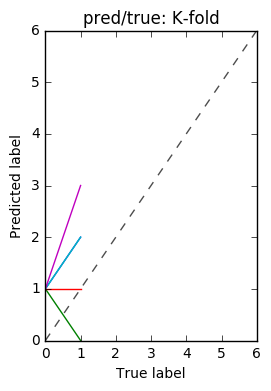

In [3]:
fig = plt.subplot(121)

plt.plot([0,6],[0,6], ls="--", c=".3")
plt.plot([0,1],[1,2])
for i in range(4):
    plt.title("pred/true: K-fold")
    plt.plot([0,1],[1,i])
    plt.xlabel("True label")
    plt.ylabel("Predicted label")


##### Determine functions

Compatible Models:

- **Ordinary Least Squares**: OLS
        Parameters: coef0
- **Random Forests (Classification + Regression)** : forestReg, forestClass
        Parameters: max_depth, max_features, min_samples
- **Ridge Regressen**: ridge
        Parameters: alpha, coef0
- **Lasso Regression**: lasso
        Parameters: alpha, coef0
- **Support vectors (Classification + Regression) **: SVR, SVC
        Parameters: alpha, gamma, coef0
        Kernels: poly, ...
- **Ridge kernels**:
        Parameters: alpha, gamma, coef0
        Kernels: poly, ...

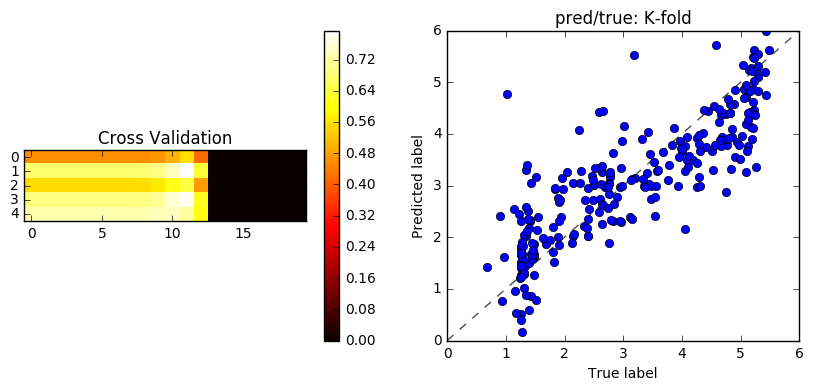

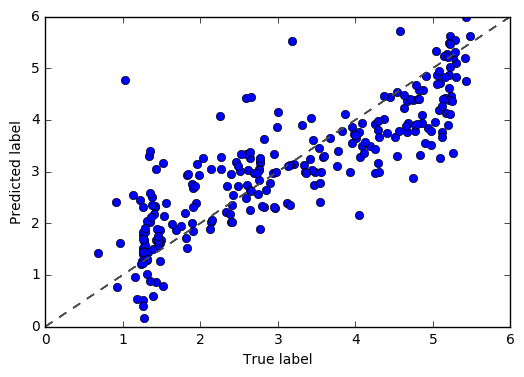

K FOLD CV 
---------- 

 Maximum Score:  0.794435842564 
 Mean optimal score:  0.703006563344 
 sd optimal scores:  0.20539481543297833 
 Optimal parEval:
 [ 10.  10.  10.  10.   1.] 
 parEval Scores:
 [[ 0.45783283  0.45783283  0.45783283  0.45783285  0.45783297  0.45783417
   0.45784623  0.45796638  0.45912884  0.46807896  0.5010585   0.55340823
   0.41771055 -0.83500947 -3.85149073 -5.33874493 -5.5618421  -5.58529868
  -5.58765642 -5.58789232]
 [ 0.67913167  0.67913167  0.67913167  0.67913169  0.67913191  0.67913404
   0.67915535  0.67936768  0.68141705  0.69670527  0.74458275  0.79443584
   0.63446973 -0.63635576 -3.4069734  -4.87374982 -5.09772864 -5.12131792
  -5.12368939 -5.12392667]
 [ 0.54991218  0.54991218  0.54991218  0.54991221  0.54991248  0.54991522
   0.54994262  0.55021508  0.55279625  0.5696688   0.61132746  0.64282474
   0.47507991 -0.52004541 -2.81423709 -4.05148846 -4.24340758 -4.2636692
  -4.26570666 -4.26591052]
 [ 0.69394467  0.69394467  0.69394468  0.6939447   0

In [4]:
plt.close('all')


# sequence region
seqRange = [-42,1]
ROI =  [[-5,14],[-8,12]]


#model selection and hyperparameters
regType = 'ridge'
kernel = 'poly'
poly= 3

# To be evaluated parameter(s)
parLabel = ['alpha']
parRange = [20] 



## OPTIONAL ##

testSize = 0.2 
k = 5 
kInner = 5
pdf = None

treeCount = 10
gamma = 0.1
alpha = 0.1
coef0 = 0.00
penalty = 0.1
epsilon = 1.95


parModel = {"regType":regType, "poly":poly, "kernel":kernel, "treeCount":treeCount, "gamma":gamma, "coef0":coef0}


###############################################
####### DO NOT TOUCH ##########################

labels, positionBox, spacer = regionSelect(dfDataset, ROI , seqRange)
positionMatrix = positionBox.values

Xdf = positionBox
X = positionMatrix
y = [math.sqrt(math.sqrt(u)) for u in labels]

if len(parLabel) is 1: 
    scoresParCV, optimalParCV = KfoldCV(X,y,k,parModel,parLabel[0],parRange[0]) 
    scoresParNCV, optimalParNCV, scoresNCV = nestedKfoldCV(X,y,k,kInner,parModel,parLabel[0],parRange[0])    
    meanScores = np.mean(np.ndarray.max(scoresParCV,axis=1))
    print("K FOLD CV \n---------- \n\n Maximum Score: ",np.max(scoresParCV), "\n Mean optimal score: ", meanScores ,"\n sd optimal scores: ", math.sqrt(np.sum(np.power((np.ndarray.max(scoresParCV,axis=1)-meanScores),2)))   , "\n Optimal parEval:\n", optimalParCV, "\n parEval Scores:\n", scoresParCV,"\n\n\n")
    print("NESTED K FOLD CV \n----------------- \n\n Maximum Score: ",np.max(scoresParNCV), "\n Mean optimal score: ", np.mean(scoresParNCV) ,"\n sd optimal scores: ", math.sqrt(np.sum(np.power((np.ndarray.max(scoresParCV,axis=1)-np.mean(scoresParNCV)),2))) , "\n Optimal parEval:\n", optimalParNCV, "\n parEval Scores:\n", scoresParNCV,"\n\n\n")

if len(parLabel) is 2:
    evaluateMultiPar(X, y, parModel, parLabel, parRange)
    
    
if (regType in ["ridge","lasso","OLS"] and poly is None): 
    reg = selectRegression(regType, alpha=np.median(optimalParCV), poly=poly, kernel=kernel) 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize) 
    reg.fit(X_train,y_train) 
    plotPositionCoefficients(reg, positionBox, posRange)


    

### Evaluate datasets using ranking scoring

Pearson's ranking

[['TTGACGGCTAGCTCAGTCCTAGGTACAGTGCTAGC' 1.0 0.6773006547906902]
 ['TTGACAGCTAGCTCAGTCCTAGGTACTGTGCTAGC' 0.86 0.6637173864464466]
 ['TTGACAGCTAGCTCAGTCCTAGGTATTGTGCTAGC' 0.72 0.7172305992508803]
 ['TTTACAGCTAGCTCAGTCCTAGGTATTATGCTAGC' 0.7 0.6948214680387206]
 ['TTGACGGCTAGCTCAGTCCTAGGTATAGTGCTAGC' 0.58 0.7330175282302626]
 ['TTGACGGCTAGCTCAGTCCTAGGTATTGTGCTAGC' 0.56 0.6706066745564058]
 ['CTGACAGCTAGCTCAGTCCTAGGTATAATGCTAGC' 0.51 0.748994095544717]
 ['TTTACGGCTAGCTCAGTCCTAGGTATAGTGCTAGC' 0.47 0.6588864157596785]
 ['TTTACGGCTAGCTCAGCCCTAGGTATTATGCTAGC' 0.36 0.6735205990348696]
 ['TTTACGGCTAGCTCAGTCCTAGGTACAATGCTAGC' 0.33 0.6560475111066038]
 ['TTTACGGCTAGCTCAGTCCTAGGTACTATGCTAGC' 0.24 0.5977600425149104]
 ['TTGACAGCTAGCTCAGTCCTAGGGACTATGCTAGC' 0.16 0.6529016547220068]
 ['TTTATAGCTAGCTCAGCCCTTGGTACAATGCTAGC' 0.15 0.6839614060584718]
 ['TTTATGGCTAGCTCAGTCCTAGGTACAATGCTAGC' 0.1 0.6115189768644659]
 ['TTGACAGCTAGCTCAGTCCTAGGGATTGTGCTAGC' 0.06 0.6558067439921897]
 ['TTTACAGCTAGCTCAGTCCTAGGGAC

<IPython.core.display.Javascript object>


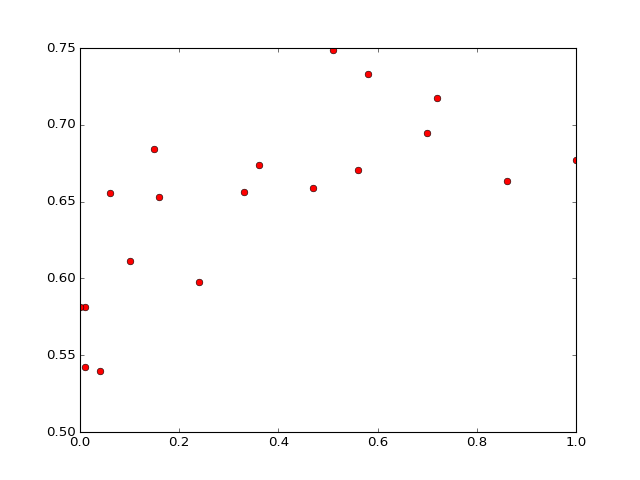

In [44]:
##################################
### TEST SETS
plt.close('all')
###################################


#data input
dfDatasetTest = pd.read_csv("data/anderson_lib.csv")

#sequence range
seqRange = [-42,1]

#regions of interest (wrt 35- and 10-box)
ROI =  [[0,12],[-12,12]]

#model selection and hyperparameters
regType = 'ridge'
kernel = 'poly'
poly= '3'

#parameters to be evaluated
parLabel = ['alpha']
parRange = [20] 

treeCount = 100
gamma = 0.1

manInput = True

parInput = {"regType":regType, "poly":poly, "kernel":kernel, "gamma":0.1, "treeCount":treeCount, "alpha": 10000, "coef0":1} 


#####################################################################################################
#####################################################################################################

# Import data for model

dfDatasetTrain = pd.read_csv("data/mut_rand_mod_lib.csv")

dfDatasetTest['sequence'] = dfDatasetTest['sequence'].str.upper()
dfDatasetTest = dfDatasetTest.sort(columns='mean_fluo',ascending=False)

labelsTrain, positionBoxTrain, spacerTrain = regionSelect(dfDatasetTrain, ROI, seqRange)
labelsTest, positionBoxTest, spacerTest = regionSelect(dfDatasetTest, ROI, seqRange)

positionMatrixTrain = positionBoxTrain.values
positionMatrixTest = positionBoxTest.values


Xdf = positionBoxTrain
X = positionMatrixTrain
y = [math.sqrt(math.sqrt(u)) for u in labelsTrain]


Xtest = positionMatrixTest
ytest = labelsTest

#############################


if manInput == False:
    
    parModel = {"regType":regType, "poly":poly, "kernel":kernel, "treeCount":treeCount, "gamma":gamma }

    parEval = getParameters(parLabel,parRange)
    reg = selectRegression(**parModel)
    GS = GridSearchCV(reg, parEval)
    GS.fit(X,y)
    reg = GS.best_estimator_
    print(GS.best_estimator_)
    
else:
    reg = selectRegression(**parInput)
    
    
reg.fit(X,y)
rankPredict = reg.predict(Xtest)

print(np.transpose(np.vstack((dfDatasetTest['sequence'].values,dfDatasetTest['mean_fluo'].values,rankPredict))))
print(stats.spearmanr(dfDatasetTest['mean_fluo'].values,rankPredict))
plt.plot(dfDatasetTest['mean_fluo'].values,rankPredict, 'ro')


[['CAGGCTTTACACTTTATGCTTCCGGCTCGGTTGTAGTGTGG' 81.46 2.058947866940735]
 ['CAGGCCTCAGACTTTATGCTTCCGGCTCGTATGTTGTGTGG' 76.0 1.5997616200232763]
 ['CAGGCCTTAGACTTTATGCTTCCGGCTCGTATGTTGTGTGG' 69.93 1.7370930476289352]
 ['TCGAGTTTACACTTTATGCTTCCGGCTCGGTTAAAGTGTGG' 69.81 2.694623079250663]
 ['CAGGCTTAAGACTTTATGCTTCCGGCTCGTATGTTGTGTGG' 69.03 1.1711003130986377]
 ['TCGAGCTCAGACTTTATGCTTCCGGCTCGTATAATGTGTGG' 64.35 2.1494215622374]
 ['TCGAGTTTACACTTTATGCTTCCGGCTCGGATAACGTGTGG' 62.58 2.858098674326108]
 ['CAGGCATTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG' 57.83 2.1804287868187977]
 ['TCGAGTTAAGACTTTATGCTTCCGGCTCGTATAATGTGTGG' 57.38 1.771957343021251]
 ['CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG' 53.45 2.376406828654236]
 ['TCGAGTTTACACTTTATGCTTCCGGCTCGGATAATGTGTGG' 51.76 3.125300415664322]
 ['TCGTGTTTACCCTTTATGCTTCCGGCTCGTATAATGTGTGG' 49.57 2.8491658059885996]
 ['TCGAGTTTACACTTTATGCTTCCGGCTCGAATAATGTGTGG' 46.74 3.019206249758236]
 ['TCGAGATTACACTTTATGCTTCCGGCTCGTATAATGTGTGG' 46.18 2.9794402588416293]
 ['

<IPython.core.display.Javascript object>


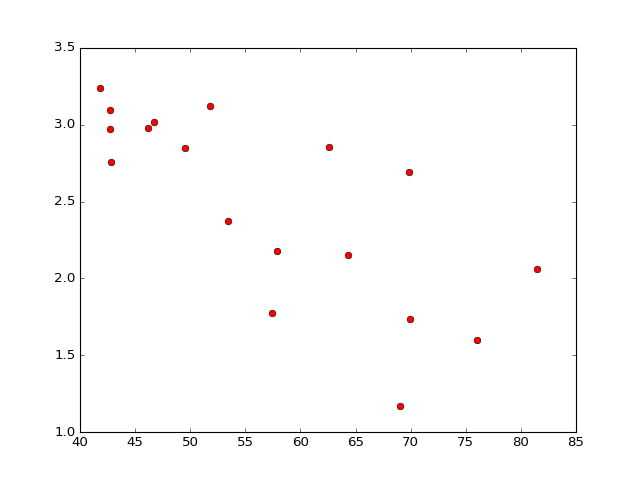

In [46]:
##################################
### TEST SETS
plt.close('all')
###################################

#data input
dfDatasetTest = pd.read_csv("data/brewster_lib.csv")


#sequence range
seqRange = [-42,1]

#regions of interest (wrt 35- and 10-box)
ROI =  [[-5,13],[-8,12]]

#model selection and hyperparameters
regType = 'ridge'
kernel = 'poly'
poly= '3'

#parameters to be evaluated
parLabel = ['alpha']
parRange = [20] 

treeCount = 100
gamma = 0.1


# Evaluate for best hyperparameters <-> Manual input
manInput = True

parInput =  {"regType":regType, "poly":poly, "kernel":kernel, "gamma":0.1, "treeCount":treeCount, "alpha": 0.000001, "coef0":1 } 
    

#####################################################################################################
#####################################################################################################

# Import data for model

dfDatasetTrain = pd.read_csv("data/mut_rand_mod_lib.csv")

dfDatasetTest['sequence'] = dfDatasetTest['sequence'].str.upper()
dfDatasetTest = dfDatasetTest.sort(columns='mean_fluo',ascending=False)

labelsTrain, positionBoxTrain, spacerTrain = regionSelect(dfDatasetTrain, ROI, seqRange)
labelsTest, positionBoxTest, spacerTest = regionSelect(dfDatasetTest, ROI, seqRange)

positionMatrixTrain = positionBoxTrain.values
positionMatrixTest = positionBoxTest.values


Xdf = positionBoxTrain
X = positionMatrixTrain
y = [math.sqrt(math.sqrt(u)) for u in labelsTrain]


Xtest = positionMatrixTest
ytest = labelsTest

#############################


if manInput == False:
    
    parModel = {"regType":regType, "poly":poly, "kernel":kernel, "treeCount":treeCount, "gamma":gamma }

    parEval = getParameters(parLabel,parRange)
    reg = selectRegression(**parModel)
    GS = GridSearchCV(reg, parEval)
    GS.fit(X,y)
    reg = GS.best_estimator_
    print(GS.best_estimator_)
    
else:
    reg = selectRegression(**parInput)
    
reg.fit(X,y)
rankPredict = reg.predict(Xtest)

print(np.transpose(np.vstack((dfDatasetTest['sequence'].values,dfDatasetTest['mean_fluo'].values,rankPredict))))
print(stats.spearmanr(dfDatasetTest['mean_fluo'].values,rankPredict))
plt.plot(dfDatasetTest['mean_fluo'].values,rankPredict, 'ro')



In [1]:
dfDatasetTest.style

NameError: name 'dfDatasetTest' is not defined

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15.0,
           max_features=None, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
[[ 'CTTCATTCTATAAGTTTCTTGACATCTTGGCCGGCATATGGTATAATAGGGAAATTTCCATGGCGGCCGCTCTAGAAGAAGCTTGGGATCCGTCGACCTCGAATTCGGAGGAAACAAAGATG'
  7606.83 4.862701708999151]
 [ 'CTTACATGAAAAAGGTTCTTGACATTTTAAATCCATGTGGTATATGTCATTTTTCCATGGCGGCCGCTCTAGAAGAAGCTTGGGATCCGTCGACCTCGAATTCGGAGGAAACAAAGATG'
  7176.96 3.273334465022138]
 [ 'CTTTGTCGGAAAACATTCTTACATTTTCAGCCAATATGATATAATTCGCGGGTTACCATGGCGGCCGCTCTAGAAGAAGCTTGGGATCCGTCGACCTCGAATTCGGAGGAAACAAAGATG'
  6852.0 3.610108296685446]
 [ 'GCATTGACGAAAACGTTCTTGACATGTTTTGCAGTTTATGGTATAATTTCGGAATTACCATGGCGGCCGCTCTAGAAGAAGCTTGGGATCCGTCGACCTCGAATTCGGAGGAAACAAAGATG'
  5422.75 4.924092811617408]
 [ 'CTTTAGCCTAAATGGTTC

<IPython.core.display.Javascript object>


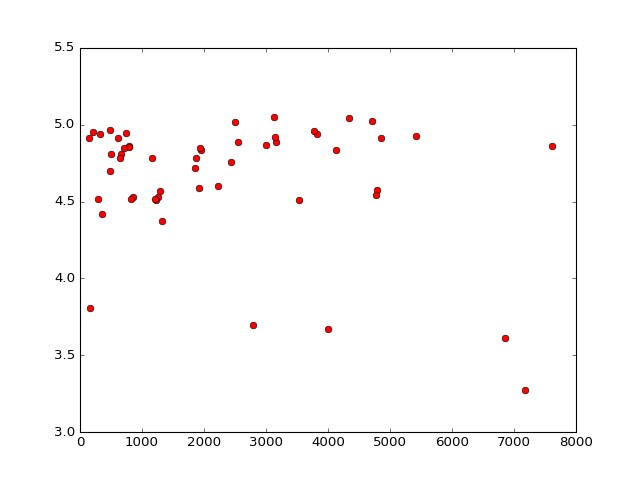

In [68]:
##################################
### TEST SETS
plt.close('all')
###################################

#data input
dfDatasetTest = pd.read_csv("data/inbio_lib.csv")


#sequence range
seqRange = [-45,1]

#regions of interest (wrt 35- and 10-box)
ROI =  [[-7,12],[-8,11]]

#model selection and hyperparameters
regType = 'forestReg'
kernel = None
poly= None

#parameters to be evaluated
parLabel = ['max_depth']
parRange = [50] 

treeCount = 100
gamma = 0.1


parModelTweak =  {"regType":regType, "poly":poly, "kernel":kernel, "gamma":0.0001, "treeCount":treeCount, "alpha": 1.0, "coef0":0.1 } 

evaluateMutalik(dfDatasetTest, ROI, seqRange, parInput)



In [3]:
##################################
### TEST SETS
plt.close('all')
###################################

#data input
dfDatasetTest = pd.read_csv("data/hammer_lib.csv")


#sequence range
seqRange = [-45,1]

#regions of interest (wrt 35- and 10-box)
ROI =  [[-7,14],[-8,11]]

#model selection and hyperparameters
regType = 'ridge'
kernel = 'poly'
poly= 3

#parameters to be evaluated
parLabel = ['alpha']
parRange = [50] 

treeCount = 100
gamma = 0.1


# Evaluate for best hyperparameters <-> Manual input
manInput = False
##

parInput = {"regType":regType, "poly":poly, "kernel":kernel, "gamma":0.01, "treeCount":treeCount, "alpha": 0.01, "coef0":0.1 } 

evaluateMutalik(dfDatasetTest, ROI, seqRange, parInput)




NameError: name 'manInput' is not defined

In [32]:
plt.close('all')

#----PARAMETERS -----
Xdf = positionBox
X = XnoOut
y = YnoOut


regType = 'ridge'
poly= 3
gamma = 1
coef0 = 1

kernel = 'poly'
parLabel = ['alpha']
parRange = [15] 

testSize = 0.20 
k = 5 
kInner = 5
pdf = None
#---------------------------

parModel = {"regType":regType, "poly":poly, "kernel":kernel, "gamma":gamma, "coef0":coef0}


if len(parLabel) is 1: 
    scoresParCV, optimalParCV, OutI, OutV = KfoldCV(X,y,k,parModel,parLabel[0],parRange[0]) 
    scoresParNCV, optimalParNCV, scoresNCV = nestedKfoldCV(X,y,k,kInner,parModel,parLabel[0],parRange[0])    
    meanScores = np.mean(np.ndarray.max(scoresParCV,axis=1))
    print("K FOLD CV \n---------- \n\n Maximum Score: ",np.max(scoresParCV), "\n Mean optimal score: ", meanScores ,"\n sd optimal scores: ", math.sqrt(np.sum(np.power((np.ndarray.max(scoresParCV,axis=1)-meanScores),2)))   , "\n Optimal parEval:\n", optimalParCV, "\n parEval Scores:\n", scoresParCV,"\n\n\n")
    print("NESTED K FOLD CV \n----------------- \n\n Maximum Score: ",np.max(scoresParNCV), "\n Mean optimal score: ", np.mean(scoresParNCV) ,"\n sd optimal scores: ", math.sqrt(np.sum(np.power((np.ndarray.max(scoresParCV,axis=1)-np.mean(scoresParNCV)),2))) , "\n Optimal parEval:\n", optimalParNCV, "\n parEval Scores:\n", scoresParNCV,"\n\n\n")
if len(parLabel) is 2:
    evaluateMultiPar(X, y, parModel, parLabel, parRange)
    
if (regType in ["ridge","lasso","OLS"] and poly is None): 
    reg = selectRegression(regType, alpha=np.median(optimalParCV), poly=poly, kernel=kernel) 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testSize) 
    reg.fit(X_train,y_train) 
    plotPositionCoefficients(reg, positionBox, posRange)


K FOLD CV 
---------- 

 Maximum Score:  0.8636674365 
 Mean optimal score:  0.82419440891 
 sd optimal scores:  0.056555113388595396 
 Optimal parEval:
 [  1000.  10000.   1000.   1000.  10000.] 
 parEval Scores:
 [[ 0.70339157  0.70339157  0.70339157  0.70339157  0.70339163  0.70339216  0.70339752  0.70345111  0.70398418
   0.70905269  0.74225203  0.78447419  0.71069898  0.42680514 -0.86323757]
 [ 0.77386117  0.77386117  0.77386117  0.77386117  0.7738612   0.77386151  0.77386461  0.77389557  0.77420363
   0.77713337  0.7966842   0.83691832  0.86366744  0.6795331  -0.44599599]
 [ 0.81285496  0.81285496  0.81285496  0.81285496  0.81285499  0.81285519  0.81285725  0.81287783  0.8130817   0.81494989
   0.8248565   0.83073847  0.79828143  0.54095783 -0.91545982]
 [ 0.81226191  0.81226191  0.81226191  0.81226192  0.81226193  0.81226204  0.81226322  0.81227492  0.81239128
   0.81348609  0.82016728  0.82095822  0.75534359  0.52605366 -0.71299687]
 [ 0.7616594   0.7616594   0.7616594   0.7616

In [11]:

dfDatasetTest = querySQL('prom_test_data', 'SELECT  sequence, mean_fluo, 35boxstart, 10boxstart, ID  FROM hammer_prom_lib')

dfDatasetTest['sequence'] = dfDatasetTest['sequence'].str.upper()
datasetUnsorted = dfDatasetTest.values
dataset = datasetUnsorted[datasetUnsorted[:,1].argsort()][::-1]


sequences= dataset[:,0]
yData = dataset[:,1]
start35Box = dataset[:,2]
start10Box = dataset[:,3]

ID = dataset[:,4]

posRange = [-35,1]
XtestBox, spacerTest = regionSelect(dataset, [[0,10],[-6,12]], test=positionBox)
Xtest = XtestBox.values

regType = 'ridge'
poly= 3
gamma = 1
coef0 = 1
alpha = 1000
kernel = 'poly'

testSize = 0.20 
k = 5 
kInner = 5
pdf = None
#---------------------------

parModel = {"regType":regType, "poly":poly, "kernel":kernel, "gamma":gamma, "coef0":coef0, "alpha":alpha}

reg = selectRegression(**parModel)
reg.fit(X,y)
rankPredict = reg.predict(Xtest)

print(np.transpose(np.vstack((sequences,yData,rankPredict))))

print(stats.spearmanr(yData,rankPredict))
print(stats.spearmanr(rankPredict,yData))



[['CTTTGGCAGTTTATTCTTGACATGTAGTGAGGGGGCTGGTATAATCACATAGTACTGTT' 528.0 5.708700659453884]
 ['CATGTGGGAGTTTATTCTTGACACAGATATTTCCGGATGATATAATAACTGAGTACTGTT' 280.0 5.708700659453884]
 ['TATGCGGTAGTTTATTCTTGACATGACGAGACAGGTGTGGTATAATGGGTCTAGATTAGG' 134.0 5.708700659453884]
 ['CATATACAAGTTTATTCTTGACACTAGTCGGCCAAAATGATATAATACCTGAGTACTGTT' 101.0 5.708700659453884]
 ['CATAGAGAAGTTTATTCTTGACAGCTAACTTGGCCTTTGATATAATACATGAGTACTGTT' 92.0 5.708700659453884]
 ['CATACGGGAGTTTATTCTTGACATATTGCCGGTGTGTTGGTATAATAACTTAGTACTGTT' 60.0 5.708700659453884]
 ['CATAGTCTAGTTTATTCTTGACACGCGGTCCATTGGCTGGTATAATAATTTAGTACTGTT' 56.0 5.708700659453884]
 ['CATGACAGAGTTTATTCTTGACAGTATTGGGTTACTTTGGTATAATAGTTGAGTACTGTT' 42.0 5.708700659453884]
 ['CATCGGGTAGTTTATTCTTGACAATTAAGTAGAGCCTGATATAATAGTTCAGTACTGTT' 34.0 5.399529980199178]
 ['CATGATGTAGTTTATTCTTGACACTGAGAGGGCCTCTTGATATAATAGTTGAGTACTGTT' 33.0 5.708700659453886]
 ['CATGGGTGAGTTTATTCTTGACAGTGCGGCCGGGGGCTGATATCATAGCAGAGTACTATT' 22.0 4.632584202374565]
 ['CATAGAACAGTTTATT

In [121]:
""" LINEAR REGRESSION USING OTHER ELEMENTS

# Query sequences, fluorescence level, reference regions

resultset =  np.squeeze(querySQL('mutalik_prom_lib','SELECT sequence, mean_fluo, 35boxstart, 10boxstart FROM rand_prom_lib').values)

sequences= resultset[:,0]
score = resultset[:,1]
start35Box = resultset[:,2]
start10Box = resultset[:,3]

# Selecting regions

box10 = selectRegions(sequences, [0,6], start10Box)
box35 = selectRegions(sequences, [0,6], start35Box)
spacer = start10Box-start35Box-6

# Creating features


fractionA_10, fractionT_10, fractionC_10, fractionG_10 = extractATCGpercentage(box10)
fractionA_35, fractionT_35, fractionC_35, fractionG_35 = extractATCGpercentage(box35)

fractionGC = [(o+p+q+r)/4 for o,p,q,r in zip(fractionC_10,fractionG_10,fractionC_35,fractionG_35)]
fractionAT = [(o+p+q+r)/4 for o,p,q,r in zip(fractionA_10,fractionT_10,fractionA_35,fractionT_35)]


featureMatrix = np.transpose(np.array([fractionGC,spacer]))


#print(featureMatrix)

print(np.shape(spacer),np.shape(score))
# Fit linear regression

linReg = LinearRegression(fit_intercept=True, normalize=True)
linReg.fit(featureMatrix, score)

#linReg.fit(np.squeeze(spacer), np.squeeze(score))

print(linReg.coef_)
print(linReg.intercept_)


# Plot coefficients
index = np.arange(np.shape(featureMatrix)[1])
coefPlot = plt.bar(index, linReg.coef_, 0.10 )
intPlot = plt.bar(-1, linReg.intercept_, 0.10)
plt.axhline(0, color='black')
plt.axvline(0, color='black')


(138,) (138,)
[-311.19084743   68.32928228]
-1000.49146613


In [ ]:
######################### EXPERIMENTAL GROUNDS ###############################################


"""
topScores= np.empty([8,8])
topCombinations = np.empty([8,8])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20)
logIt = [math.pow(10,u) for u in range(-3,5)]
for i in logIt:
    index = int(math.log10(i)+3)
    combinations, results = bestSubsetSelection(X_train, X_test, y_train, y_test,2, 'ridge', alpha=i)
    print(results[0:8])
    print(combinations[0:8])"""








